In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Build a fraud detection model on Vertex AI

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/fraud_detection/fraud-detection-model.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/fraud_detection/fraud-detection-model.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
   <td>
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/workbench/fraud_detection/fraud-detection-model.ipynb" target='_blank'>
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Overview

This tutorial shows you how to build, deploy, and analyze predictions from a simple [random forest](https://en.wikipedia.org/wiki/Random_forest) model using tools like scikit-learn, Vertex AI, and the [What-IF Tool (WIT)](https://cloud.google.com/ai-platform/prediction/docs/using-what-if-tool) on a synthetic fraud transaction dataset to solve a financial fraud detection problem.

Learn more about [Vertex AI Workbench](https://cloud.google.com/vertex-ai/docs/workbench/introduction) and [Custom training](https://cloud.google.com/vertex-ai/docs/training/custom-training).

### Objective

This tutorial demonstrates data analysis and model-building using a synthetic financial dataset. The model is trained on identifying fraudulent cases among the transactions. Then, the trained model is deployed on a Vertex AI Endpoint and analyzed using the What-If Tool. The steps taken in this tutorial are as follows: 

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Model
- Vertex AI Endpoint

The steps performed include:

- Installation of required libraries
- Reading the dataset from a Cloud Storage bucket
- Performing exploratory analysis on the dataset
- Preprocessing the dataset
- Training a random forest model using scikit-learn
- Saving the model to a Cloud Storage bucket
- Creating a Vertex AI model resource and deploying to an endpoint
- Running the What-If Tool on test data
- Un-deploying the model and cleaning up the model resources

### Dataset


The dataset used in this tutorial is publicly available at Kaggle. See [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/ealaxi/paysim1).

### Costs


This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage. 

### Set up your local development environment

**If you are using Colab or Vertex AI Workbench Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

## Installation

Install the following packages required to execute this notebook. 

In [2]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

# Install the latest version of the Vertex AI client library.
# ! pip3 install --upgrade google-cloud-aiplatform witwidget scikit-learn fsspec gcsfs {USER_FLAG} -q
# ! pip3 install protobuf==3.20.1 -q

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [3]:
# Automatically restart kernel after installs
# if not os.getenv("IS_TESTING"):
#     # Automatically restart kernel after installs
#     import IPython

#     app = IPython.Application.instance()
#     app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). 

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [4]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [5]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: mwpmltr


In [6]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. It is recommended that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [7]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [8]:
# import random
# import string


# # Generate a uuid of length 8
# def generate_uuid():
#     return "".join(random.choices(string.ascii_lowercase + string.digits, k=8))


# UUID = generate_uuid()

In [9]:
UUID='0obvksai'

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "Vertex AI"
into the filter box, and select
   **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [10]:
# # If you are running this notebook in Colab, run this cell and follow the
# # instructions to authenticate your GCP account. This provides access to your
# # Cloud Storage bucket and lets you submit training jobs and prediction
# # requests.

# import os
# import sys

# # If on Vertex AI Workbench, then don't execute this code
# IS_COLAB = "google.colab" in sys.modules
# if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
#     "DL_ANACONDA_HOME"
# ):
#     if "google.colab" in sys.modules:
#         from google.colab import auth as google_auth

#         google_auth.authenticate_user()

#     # If you are running this notebook locally, replace the string below with the
#     # path to your service account key and run this cell to authenticate your GCP
#     # account.
#     elif not os.getenv("IS_TESTING"):
#         %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**


When you create a model in Vertex AI using the Cloud SDK, you give a Cloud Storage path where the trained model is saved. 
In this tutorial, Vertex AI saves the trained model to a Cloud Storage bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.


In [11]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [12]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + UUID
    BUCKET_URI = f"gs://{BUCKET_NAME}"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [13]:
# ! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [14]:
! gsutil ls -al $BUCKET_URI

                                 gs://mwpmltraip-0obvksai/artifacts/
                                 gs://mwpmltraip-0obvksai/data/
                                 gs://mwpmltraip-0obvksai/fraud-detection-model-path/
                                 gs://mwpmltraip-0obvksai/pipeline_root/


## Tutorial

### Import required libraries

In [15]:
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.cloud import aiplatform, storage
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from witwidget.notebook.visualization import WitConfigBuilder, WitWidget

warnings.filterwarnings("ignore")

2023-03-15 18:32:32.609322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 18:32:32.744332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 18:32:32.744362: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 18:32:33.693572: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Load dataset

In [16]:
df = pd.read_csv(
    "gs://cloud-samples-data/vertex-ai/managed_notebooks/fraud_detection/fraud_detection_data.csv"
)

## Analyze the dataset


Take a quick look at the dataset and the number of rows.

In [17]:
print("shape : ", df.shape)
df.head()

shape :  (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Check for null values.

In [18]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Check the type of transactions involved.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Text(0, 0.5, 'Amount')

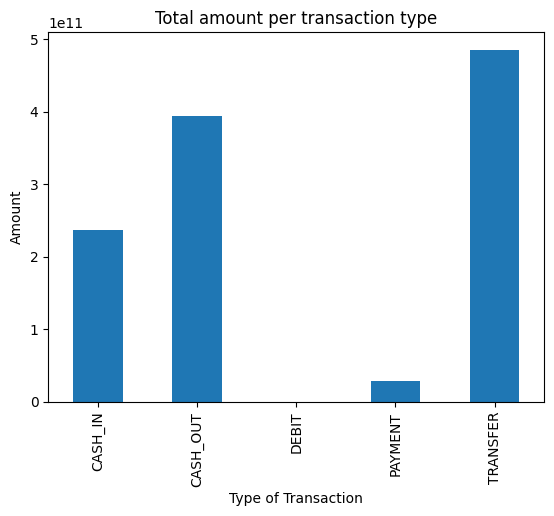

In [19]:
print(df.type.value_counts())
var = df.groupby("type").amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
var.plot(kind="bar")
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel("Type of Transaction")
ax1.set_ylabel("Amount")

## Working with imbalanced data

Althuogh the outcome variable "isFraud" seems to be very imbalanced in the current dataset, a base model can be trained on it to check the quality of fraudulent transactions in the data and if needed, counter measures like undersampling of majority class or oversampling of the minority class can be considered.

In [20]:
# Count number of fraudulent/non-fraudulent transactions
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

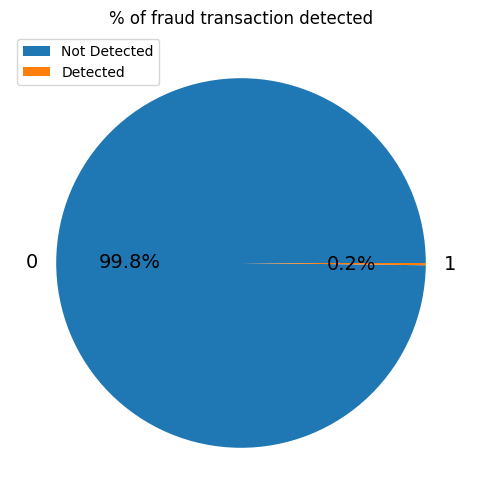

In [21]:
piedata = df.groupby(["isFlaggedFraud"]).sum()
f, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title("% of fraud transaction detected")
piedata.plot(
    kind="pie", y="isFraud", ax=axes, fontsize=14, shadow=False, autopct="%1.1f%%"
)
axes.set_ylabel("")
plt.legend(loc="upper left", labels=["Not Detected", "Detected"])
plt.show()

## Prepare data for modeling
To prepare the dataset for training, a few columns need to be dropped that contain either unique data ('nameOrig','nameDest') or redundant fields ('isFlaggedFraud'). The categorical field "type" which describes the type of transaction and is important for fraud detection needs to be one-hot encoded.


In [22]:
df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1, inplace=True)

In [23]:
X = pd.concat([df.drop("type", axis=1), pd.get_dummies(df["type"])], axis=1)
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


Remove the outcome variable from the training data.

In [24]:
y = X[["isFraud"]]
X = X.drop(["isFraud"], axis=1)

## Maven Wave: To reduce training time, we will downsample X:

In [25]:
# ! pip3 install imblearn -q

### Under-sample the majority class(es) by randomly picking samples without replacement.

In [26]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [27]:
y_res.value_counts()

isFraud
0          8213
1          8213
dtype: int64

Split the data and assign 70% for training and 30% for testing.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, shuffle=True, stratify=y_res
)
print(X_train.shape, X_test.shape)

(13140, 11) (3286, 11)


In [29]:
y_test.value_counts()

isFraud
0          1643
1          1643
dtype: int64

## Fit a random forest model

Fit a simple random forest classifier on the preprocessed training dataset.

In [30]:
print("before initiating")
forest = RandomForestClassifier(verbose=1)
print("after initiating")
forest.fit(X_train, y_train)
print("after fitting")

before initiating
after initiating


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


after fitting


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


## Analyzing Results

The model returns good scores and the confusion matrix confirms that this model can indeed work with imbalanced data.

In [31]:
print("before predicting")
y_prob = forest.predict_proba(X_test)
print("after predicting y_prob")
y_pred = forest.predict(X_test)

print("AUPRC :", (average_precision_score(y_test, y_prob[:, 1])))
print("F1 - score :", (f1_score(y_test, y_pred)))

print("Confusion_matrix : ")
print(confusion_matrix(y_test, y_pred))

print("classification_report")
print(classification_report(y_test, y_pred))
print("after printing classification_report")

before predicting
after predicting y_prob
AUPRC : 0.99945468980313
F1 - score : 0.9945454545454546
Confusion_matrix : 
[[1627   16]
 [   2 1641]]
classification_report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1643
           1       0.99      1.00      0.99      1643

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

after printing classification_report


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Use `RandomForestClassifier`'s `feature_importances_ function` to get a better understanding about which features were the most useful to the model.

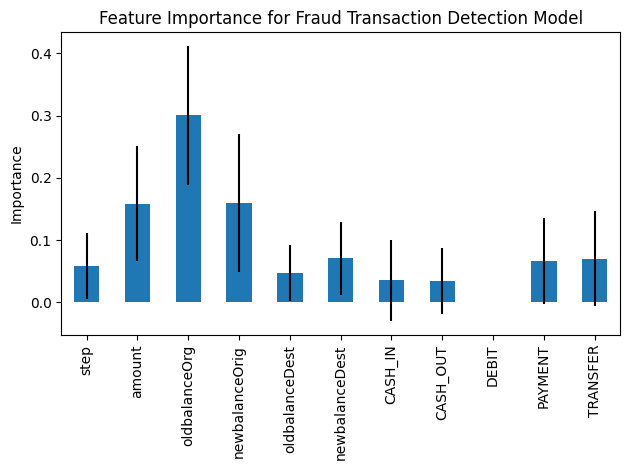

In [32]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X_train))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance for Fraud Transaction Detection Model")
ax.set_ylabel("Importance")
fig.tight_layout()

## Save the model to a Cloud Storage path


In [33]:
import os

# save the trained model to a local file "model.pkl"
FILE_NAME = "model.pkl"
with open(FILE_NAME, "wb") as file:
    pickle.dump(forest, file)

# Upload the saved model file to Cloud Storage
BLOB_PATH = "[your-blob-path]"
if BLOB_PATH == "[your-blob-path]":
    BLOB_PATH = "fraud-detection-model-path"
BLOB_NAME = os.path.join(BLOB_PATH, FILE_NAME)

bucket = storage.Client(PROJECT_ID).bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename(FILE_NAME)

## Create a model in Vertex AI


In [34]:
MODEL_DISPLAY_NAME = "[your-model-display-name]"
if MODEL_DISPLAY_NAME == "[your-model-display-name]":
    MODEL_DISPLAY_NAME = "fraud-detection-model-display-name"
ARTIFACT_GCS_PATH = f"{BUCKET_URI}/{BLOB_PATH}"
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest"
)

In [35]:
# Create a Vertex AI model resource

aiplatform.init(project=PROJECT_ID, location=REGION)

# model = aiplatform.Model.upload(
#     display_name=MODEL_DISPLAY_NAME,
#     artifact_uri=ARTIFACT_GCS_PATH,
#     serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
# )

# model.wait()

# print(model.display_name)
# print(model.resource_name)

## Create an Endpoint


In [36]:
ENDPOINT_DISPLAY_NAME = "[your-endpoint-display-name]"
if ENDPOINT_DISPLAY_NAME == "[your-endpoint-display-name]":
    ENDPOINT_DISPLAY_NAME = "fraud-detection-endpoint"

In [37]:
# endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)


# print(endpoint.display_name)
# print(endpoint.resource_name)

### Deploy the model to the created Endpoint

Configure the deployment name, machine type, and other parameters for the deployment.

In [38]:
DEPLOYED_MODEL_NAME = "[your-deployed-model-name]"
if DEPLOYED_MODEL_NAME == "[your-deployed-model-name]":
    DEPLOYED_MODEL_NAME = "fraud-detection-deployed-model"
MACHINE_TYPE = "n1-standard-2"

In [39]:
# # deploy the model to the endpoint
# model.deploy(
#     endpoint=endpoint,
#     deployed_model_display_name=DEPLOYED_MODEL_NAME,
#     machine_type=MACHINE_TYPE,
# )

# model.wait()

# print(model.display_name)
# print(model.resource_name)

## What-If Tool 

The What-If Tool can be used to analyze the model predictions on a test data. See a [brief introduction to the What-If Tool](https://pair-code.github.io/what-if-tool/). In this tutorial, the What-If Tool will be configured and run on the model trained locally, and on the model deployed on Vertex AI Endpoint in the previous steps.

[WitConfigBuilder](https://github.com/PAIR-code/what-if-tool/blob/master/witwidget/notebook/visualization.py#L30) provides the  `set_ai_platform_model()` method to configure the What-If Tool with a model deployed as a version on Ai Platform models. This feature currently supports Ai Platform only but not Vertex AI models. Fortunately, there is also an option to pass a custom function for generating predictions through the `set_custom_predict_fn()` method where either the locally trained model or a function that returns predictions from a Vertex AI model can be passed.

### Prepare test samples

Save some samples from the test data for both the available classes (Fraud/not-Fraud) to analyze the model using the What-If Tool.

In [41]:
# collect 50 samples for each class-label from the test data
pos_samples = y_test[y_test["isFraud"] == 1].sample(50).index
neg_samples = y_test[y_test["isFraud"] == 0].sample(50).index
test_samples_y = pd.concat([y_test.loc[pos_samples], y_test.loc[neg_samples]])
test_samples_X = X_test.loc[test_samples_y.index].copy()

### Running the What-If Tool on the local model

In [30]:
# ! jupyter nbextension install --py --symlink --sys-prefix witwidget
# ! jupyter nbextension enable --py --sys-prefix witwidget

# !jupyter labextension install wit-widget
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

Building jupyterlab assets (production, minimized)
Building jupyterlab assets (production, minimized)


In [50]:
IS_COLAB=False

In [53]:
if not IS_COLAB:
    # define target and labels
    TARGET_FEATURE = "isFraud"
    LABEL_VOCAB = ["not-fraud", "fraud"]

    # define the function to adjust the predictions

    def adjust_prediction(pred):
        return [1 - pred, pred]

    # Combine the features and labels into one array for the What-If Tool
    test_examples = np.hstack(
        (test_samples_X.to_numpy(), test_samples_y.to_numpy().reshape(-1, 1))
    )

    # Configure the WIT to run on the locally trained model
    config_builder = (
        WitConfigBuilder(
            test_examples.tolist(), test_samples_X.columns.tolist() + ["isFraud"]
        )
        .set_custom_predict_fn(forest.predict_proba)
        .set_target_feature(TARGET_FEATURE)
        .set_label_vocab(LABEL_VOCAB)
    )

    # display the WIT widget
    display(WitWidget(config_builder, height=600))

WitWidget(config={'model_type': 'classification', 'label_vocab': ['not-fraud', 'fraud'], 'feature_names': ['st…

In [46]:
if IS_COLAB:
    # define target and labels
    TARGET_FEATURE = "isFraud"
    LABEL_VOCAB = ["not-fraud", "fraud"]

    # define the function to adjust the predictions

    def adjust_prediction(pred):
        return [1 - pred, pred]

    # Combine the features and labels into one array for the What-If Tool
    test_examples = np.hstack(
        (test_samples_X.to_numpy(), test_samples_y.to_numpy().reshape(-1, 1))
    )

    # Configure the WIT to run on the locally trained model
    config_builder = (
        WitConfigBuilder(
            test_examples.tolist(), test_samples_X.columns.tolist() + ["isFraud"]
        )
        .set_custom_predict_fn(forest.predict_proba)
        .set_target_feature(TARGET_FEATURE)
        .set_label_vocab(LABEL_VOCAB)
    )

    # display the WIT widget
    WitWidget(config_builder, height=600)
    

### Running the What-If Tool on the deployed Vertex AI model

In [44]:
IS_COLAB=True
aiplatform.init(project=PROJECT_ID, location=REGION)
endpoint = aiplatform.Endpoint('projects/55590906972/locations/us-central1/endpoints/4825479457378664448')

In [45]:
if IS_COLAB:
    # configure the target and class-labels
    TARGET_FEATURE = "isFraud"
    LABEL_VOCAB = ["not-fraud", "fraud"]

    # function to return predictions from the deployed Model

    def endpoint_predict_sample(instances: list):
        prediction = endpoint.predict(instances=instances)
        preds = [[1 - i, i] for i in prediction.predictions]
        return preds

    # Combine the features and labels into one array for the What-If Tool
    test_examples = np.hstack(
        (test_samples_X.to_numpy(), test_samples_y.to_numpy().reshape(-1, 1))
    )

    # Configure the WIT with the prediction function
    config_builder = (
        WitConfigBuilder(
            test_examples.tolist(), test_samples_X.columns.tolist() + ["isFraud"]
        )
        .set_custom_predict_fn(endpoint_predict_sample)
        .set_target_feature(TARGET_FEATURE)
        .set_label_vocab(LABEL_VOCAB)
    )

    # run the WIT-widget
    display(WitWidget(config_builder, height=400))

WitWidget(config={'model_type': 'classification', 'label_vocab': ['not-fraud', 'fraud'], 'feature_names': ['st…

## Undeploy the model
When you are done doing predictions, you undeploy the model from the Endpoint resouce. This deprovisions all compute resources and ends billing for the deployed model.

In [46]:
endpoint.undeploy_all()

Undeploying Endpoint model: projects/55590906972/locations/us-central1/endpoints/7943096299425890304
Undeploy Endpoint model backing LRO: projects/55590906972/locations/us-central1/endpoints/7943096299425890304/operations/8823160593302159360
Endpoint model undeployed. Resource name: projects/55590906972/locations/us-central1/endpoints/7943096299425890304


resource name: projects/55590906972/locations/us-central1/endpoints/7943096299425890304

## Clean up


To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [47]:
# delete the endpoint
endpoint.delete()

# delete the model
model.delete()

delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -r $BUCKET_URI

Deleting Endpoint : projects/55590906972/locations/us-central1/endpoints/7943096299425890304
Delete Endpoint  backing LRO: projects/55590906972/locations/us-central1/operations/464479684902518784
Endpoint deleted. . Resource name: projects/55590906972/locations/us-central1/endpoints/7943096299425890304
Deleting Model : projects/55590906972/locations/us-central1/models/6546107402708582400
Delete Model  backing LRO: projects/55590906972/locations/us-central1/operations/6902375352228642816
Model deleted. . Resource name: projects/55590906972/locations/us-central1/models/6546107402708582400
